# Tutorial 2: Dynamic Entry-Exit Games with CCP Estimation

This notebook implements the dynamic entry-exit game from Section 7.2 of:

**"Conditional Choice Probability Estimation of Dynamic Discrete Choice Models With Unobserved Heterogeneity"**
*Arcidiacono & Miller, Econometrica (2011)*

## Overview
### Part 1: Generic Framework
- State enumeration and indexing
- Policy iteration for equilibrium
- Abstract interface for dynamic models
- Models with terminal action (Hotz-Miller tractable)

### Part 2: Entry-Exit Game (Solving Equilibrium and Simulation)
- Structural parameters
- Full game implementation with CCP operator
- Equilibrium solving via policy iteration
- Simulation of panel data

### Part 3: Estimation
- **NFXP**: Full solution benchmark (MLE)
- **Two-Stage**: Fast CCP method (linear in parameters)
- **CCP-Model (NPL)**: Iteratively improves efficiency

## 0.1 Setup

In [1]:
import numpy as np
import pandas as pd
from tabulate import tabulate
from scipy.optimize import minimize
from scipy.special import comb, softmax
from dataclasses import dataclass, field
from typing import Tuple, Dict, List, Optional, Callable, Any, Union
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

EULER_CONSTANT = 0.5772156649015329

### 0.2 Logit Utilities

In [2]:
def logit_prob_binary(v: np.ndarray) -> np.ndarray:
    """
    Binary logit: convert value difference to choice probability.

    Parameters
    ----------
    v : array, shape (n_states,)
        Value difference v_1 - v_0 for each state

    Returns
    -------
    array, shape (n_states,)
        P(d=1 | x) for each state
    """
    v = np.asarray(v, dtype=float)
    result = np.zeros_like(v)
    pos = v >= 0
    result[pos] = 1.0 / (1.0 + np.exp(-v[pos]))
    result[~pos] = np.exp(v[~pos]) / (1.0 + np.exp(v[~pos]))
    return result


def logit_prob_multinomial(v: np.ndarray) -> np.ndarray:
    """
    Multinomial logit: convert values to choice probabilities.

    Parameters
    ----------
    v : array, shape (n_states, n_actions)
        Value v(x, d) for each state-action pair

    Returns
    -------
    array, shape (n_states, n_actions)
        P(d | x) for each state-action pair (rows sum to 1)
    """
    # Use scipy's softmax for numerical stability
    return softmax(v, axis=1)


def log_odds(p: np.ndarray) -> np.ndarray:
    """
    Inverse of binary logit (Hotz-Miller inversion).

    Parameters
    ----------
    p : array
        Choice probabilities P(d=1 | x)

    Returns
    -------
    array
        Value differences v_1 - v_0
    """
    p = np.clip(p, 1e-10, 1 - 1e-10)
    return np.log(p / (1 - p))


def emax_logit(p: np.ndarray) -> np.ndarray:
    """
    Ex-ante value from CCPs (Hotz-Miller formula for binary logit).

    V(x) = E[max{v_0 + eps_0, v_1 + eps_1}] = gamma - log(1 - p_1)

    (Assumes v_0 = 0, so this is relative to action 0.)

    Parameters
    ----------
    p : array
        P(d=1 | x) for each state

    Returns
    -------
    array
        Ex-ante value V(x) for each state
    """
    p = np.clip(p, 1e-10, 1 - 1e-10)
    return EULER_CONSTANT - np.log(1 - p)


# Test
print("Binary logit tests:")
print(f"  v=0 → p={logit_prob_binary(0):.3f} (should be 0.5)")
print(f"  v=2 → p={logit_prob_binary(2):.3f}")
print(f"  p=0.7 → v={log_odds(0.7):.3f}")
print(f"  Round-trip: p=0.7 → v → p={logit_prob_binary(log_odds(0.7)):.3f}")

print("\nMultinomial logit test:")
v_test = np.array([[0, 1, 2], [1, 1, 1]])  # 2 states, 3 actions
p_test = logit_prob_multinomial(v_test)
print(f"  Values: {v_test[0]} → Probs: {p_test[0].round(3)} (sum={p_test[0].sum():.3f})")
print(f"  Values: {v_test[1]} → Probs: {p_test[1].round(3)} (sum={p_test[1].sum():.3f})")

Binary logit tests:
  v=0 → p=0.500 (should be 0.5)
  v=2 → p=0.881
  p=0.7 → v=0.847
  Round-trip: p=0.7 → v → p=0.700

Multinomial logit test:
  Values: [0 1 2] → Probs: [0.09  0.245 0.665] (sum=1.000)
  Values: [1 1 1] → Probs: [0.333 0.333 0.333] (sum=1.000)


---
# Part 1: Generic Framework

## Class Hierarchy

```
StateSpace              → State enumeration with index mapping
FixedPointSolver        → Solves x* = T(x*) via iteration

DynamicModel (ABC)      → Interface for any DDC model
    ├── state_space, n_actions, discount
    ├── flow_utility(x, d), transition_probs(x, d)
    ├── ccp_operator(ccps)  [abstract]
    └── solve()             [uses FixedPointSolver]

FiniteDependenceModel   → For models with terminal action (exit, replace)
    ├── expected_flow_utility(ccps)     [abstract]
    ├── continuation_value_diff(ccps)   [abstract]  
    ├── ex_ante_value(ccps)             [Hotz-Miller inversion]
    └── ccp_operator(ccps)              [provided automatically]

EntryExitGame           → Concrete implementation
```

---
## 1.1 StateSpace

Maps states ↔ integer indices for array storage.

```python
ss = StateSpace([('home','am'), ('home','pm'), ('work','am'), ('work','pm')])
ss.n_states                        # 4
ss.state_to_index(('work','am'))   # 2
ss.index_to_state(2)               # ('work','am')
```

In [3]:
class StateSpace:
    """
    A collection of states with integer indexing.
    
    This class:
    - Stores all possible states
    - Maps states to indices (for array storage)
    - Maps indices back to states (for interpretation)
    
    States can be any hashable type: tuples, ints, strings, etc.
    """
    
    def __init__(self, states: List[Any]):
        """
        Create state space from list of states.
        
        Parameters
        ----------
        states : list
            All possible states. Order determines indexing.
        """
        self._states = list(states)
        self._index_map = {s: i for i, s in enumerate(self._states)}
    
    @property
    def n_states(self) -> int:
        """Number of states."""
        return len(self._states)
    
    def state_to_index(self, state: Any) -> int:
        """Get integer index for a state."""
        return self._index_map[state]
    
    def index_to_state(self, idx: int) -> Any:
        """Get state for an integer index."""
        return self._states[idx]
    
    def states(self) -> List[Any]:
        """Return list of all states."""
        return self._states.copy()
    
    def __len__(self) -> int:
        return len(self._states)
    
    def __iter__(self):
        return iter(self._states)
    
    def __repr__(self) -> str:
        return f"StateSpace(n_states={self.n_states})"

In [4]:
# Example: Simple 2D state space
print("=" * 70)
print("Example: StateSpace")
print("=" * 70)

# States are (x, y) tuples
example_states = [(x, y) for x in range(3) for y in range(2)]
ss = StateSpace(example_states)

print(f"States: {ss.states()}")
print(f"Number of states: {ss.n_states}")

print(f"\nMapping examples:")
print(f"  state (1, 0) → index {ss.state_to_index((1, 0))}")
print(f"  index 3 → state {ss.index_to_state(3)}")

print(f"\nUsing with arrays:")
values = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0])  # One value per state
print(f"  Values array: {values}")
print(f"  Value at state (2, 1): {values[ss.state_to_index((2, 1))]}")

Example: StateSpace
States: [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1)]
Number of states: 6

Mapping examples:
  state (1, 0) → index 2
  index 3 → state (1, 1)

Using with arrays:
  Values array: [1. 2. 3. 4. 5. 6.]
  Value at state (2, 1): 6.0


---
## 1.2 FixedPointSolver

Finds $x^*$ such that $x^* = T(x^*)$ via iteration.

**Applications**: Value function iteration ($V^* = T_V(V^*)$), equilibrium CCPs ($p^* = \Psi(p^*)$).

In [5]:
@dataclass
class FixedPointResult:
    """Results from fixed-point iteration."""
    solution: np.ndarray       # The fixed point x*
    n_iterations: int          # Iterations used
    converged: bool            # Did it converge?
    final_diff: float          # ||x_new - x|| at end
    computation_time: float    # Seconds


class FixedPointSolver:
    """
    Solve x* = T(x*) by iteration.
    
    Works for ANY operator T that maps arrays to arrays.
    """
    
    def __init__(self, 
                 operator: Callable[[np.ndarray], np.ndarray],
                 tolerance: float = 1e-8,
                 max_iter: int = 1000,
                 verbose: bool = True):
        """
        Parameters
        ----------
        operator : callable
            Function T(x) → x
        tolerance : float
            Stop when max|x_new - x| < tolerance
        max_iter : int
            Maximum iterations
        verbose : bool
            Print progress
        """
        self.operator = operator
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.verbose = verbose
    
    def solve(self, initial: np.ndarray) -> FixedPointResult:
        """
        Find fixed point starting from initial guess.
        
        Parameters
        ----------
        initial : np.ndarray
            Starting point
        
        Returns
        -------
        FixedPointResult
        """
        start = time.time()
        x = initial.copy()
        
        for iteration in range(self.max_iter):
            x_new = self.operator(x)
            diff = np.max(np.abs(x_new - x))
            
            if self.verbose and (iteration + 1) % 50 == 0:
                print(f"  Iter {iteration+1}: diff = {diff:.2e}")
            
            if diff < self.tolerance:
                if self.verbose:
                    print(f"  Converged in {iteration+1} iterations")
                return FixedPointResult(x_new, iteration+1, True, diff, time.time()-start)
            
            x = x_new
        
        if self.verbose:
            print(f"  Did not converge after {self.max_iter} iterations")
        return FixedPointResult(x, self.max_iter, False, diff, time.time()-start)

In [6]:
# Example: Find fixed point of T(x) = 0.5*x + 3
# Analytically: x* = 0.5*x* + 3 → x* = 6

print("=" * 70)
print("Example: FixedPointSolver")
print("=" * 70)
print("Finding x* where x* = 0.5*x + 3")
print("Analytical solution: x* = 6")
print("")

def simple_operator(x):
    return 0.5 * x + 3

solver = FixedPointSolver(simple_operator, tolerance=1e-6, verbose=False)
result = solver.solve(np.array([0.0]))

print(f"Numerical solution: x* = {result.solution[0]:.6f}")
print(f"Iterations: {result.n_iterations}")
print(f"Converged: {result.converged}")

Example: FixedPointSolver
Finding x* where x* = 0.5*x + 3
Analytical solution: x* = 6

Numerical solution: x* = 5.999999
Iterations: 23
Converged: True


---
## 1.3 DynamicModel (Abstract Base Class)

| Property/Method | Description |
|-----------------|-------------|
| `state_space` | StateSpace object |
| `n_actions` | Number of discrete choices |
| `discount` | $\beta$ |
| `flow_utility(x, d)` | Per-period payoff $u(x, d)$ |
| `transition_probs(x, d)` | $P(x' \mid x, d)$ |
| `ccp_operator(ccps)` | Maps $p \to p'$ (best response) |
| `solve()` | Find equilibrium via FixedPointSolver |

In [7]:
class DynamicModel(ABC):
    """
    Abstract base class for dynamic discrete choice models.
    
    Defines the interface that any DDC model must implement.
    Works for single-agent problems and games.
    Works for binary and multinomial choice.
    """
    
    # --- Properties (must implement) ---
    
    @property
    @abstractmethod
    def state_space(self) -> StateSpace:
        """The state space."""
        pass
    
    @property
    @abstractmethod
    def n_actions(self) -> int:
        """Number of actions (2 for binary, >2 for multinomial)."""
        pass
    
    @property
    @abstractmethod
    def discount(self) -> float:
        """Discount factor β."""
        pass
    
    # --- Methods (must implement) ---
    
    @abstractmethod
    def flow_utility(self, state: Any, action: int) -> float:
        """
        Flow utility u(x, d).
        
        Parameters
        ----------
        state : Any
            Current state
        action : int
            Action (0 to n_actions-1)
        
        Returns
        -------
        float
            Per-period payoff
        """
        pass
    
    @abstractmethod
    def transition_probs(self, state: Any, action: int) -> Dict[Any, float]:
        """
        Transition probabilities P(x' | x, d).
        
        Parameters
        ----------
        state : Any
            Current state
        action : int
            Action taken
        
        Returns
        -------
        dict
            {next_state: probability} (must sum to 1)
        """
        pass
    
    @abstractmethod
    def ccp_operator(self, ccps: np.ndarray) -> np.ndarray:
        """
        CCP operator: maps CCPs to best-response CCPs.
        
        For single-agent: derived from Bellman equation
        For games: best response to others' strategies
        
        Parameters
        ----------
        ccps : np.ndarray
            Current CCPs
            - Binary: shape (n_states,) = P(d=1|x)
            - Multinomial: shape (n_states, n_actions) = P(d|x)
        
        Returns
        -------
        np.ndarray
            Updated CCPs (same shape)
        """
        pass
    
    # --- Concrete methods (provided) ---
    
    def solve(self, 
              initial_ccps: np.ndarray = None,
              tolerance: float = 1e-8,
              max_iter: int = 1000,
              verbose: bool = True) -> FixedPointResult:
        """
        Solve for equilibrium/optimal CCPs.
        
        Finds p* such that p* = Ψ(p*).
        """
        if initial_ccps is None:
            if self.n_actions == 2:
                initial_ccps = 0.5 * np.ones(self.state_space.n_states)
            else:
                initial_ccps = np.ones((self.state_space.n_states, self.n_actions)) / self.n_actions
        
        solver = FixedPointSolver(self.ccp_operator, tolerance, max_iter, verbose)
        return solver.solve(initial_ccps)

---
## 1.4 FiniteDependenceModel

For models with a **terminal action** (exit, replace, stop) that resets state.

**Key insight**: Hotz-Miller inversion recovers values from CCPs:
$$V(x) = \gamma - \log(1 - p(x))$$

**Subclasses implement**:
- `expected_flow_utility(ccps)` → $E[u_1 - u_0]$
- `continuation_value_diff(ccps)` → $E[V'|d=1] - E[V'|d=0]$

**Base class provides**: `ccp_operator(ccps)` automatically.

In [8]:
class FiniteDependenceModel(DynamicModel):
    """
    Base class for models with a terminal (reference) action.
    
    Two normalizations are supported:
    
    1. STANDARD (single-agent): 
       - u_terminal = 0 (flow utility of terminal action)
       - continuation_value_diff returns: E[V'|d] - E[V'|terminal]
       - v_d - v_terminal = (u_d - 0) + β·(E[V'|d] - E[V'|terminal])
    
    2. GAME (following Arcidiacono-Miller MATLAB):
       - v_terminal = 0 (entire value of terminal action, not just flow)
       - continuation_value_diff returns: E[V'|d=operate] directly
       - v_operate - v_terminal = E[U] + β·E[V'|d=operate] - 0
    
    The ccp_operator works for both: it computes v_diff = u_diff + β·cv_diff
    and applies logit. The interpretation of cv_diff depends on normalization.
    
    Hotz-Miller inversion: V(x) = γ - log(p_terminal(x))
    
    Works for:
    - Binary choice (K=2): d ∈ {0, 1}, terminal action 0
    - Multinomial choice (K>2): d ∈ {0, 1, ..., K-1}, any terminal action
    
    Subclasses must implement:
    - expected_flow_utility(ccps): E[u_d] or E[u_d - u_terminal]
    - continuation_value_diff(ccps): E[V'|d] or E[V'|d] - E[V'|terminal]
    - terminal_action property: which action is reference (default: 0)
    """
    
    # --- Properties (can override) ---
    
    @property
    def terminal_action(self) -> int:
        """Index of terminal (reference) action. Default is 0."""
        return 0
    
    # --- Abstract methods (subclass must implement) ---
    
    @abstractmethod
    def expected_flow_utility(self, ccps: np.ndarray) -> np.ndarray:
        """
        Expected flow utility for non-terminal action(s).
        
        For single-agent models: typically u_d(x) (with u_terminal = 0)
        For games: E_{rivals}[U(n*, x)] integrating over rival actions
        
        Parameters
        ----------
        ccps : np.ndarray
            Current CCPs
            - Binary (K=2): shape (n_states,) = P(d=1|x)
            - Multinomial (K>2): shape (n_states, K) = P(d|x)
        
        Returns
        -------
        np.ndarray
            - Binary: shape (n_states,)
            - Multinomial: shape (n_states, K-1)
        """
        pass
    
    @abstractmethod
    def continuation_value_diff(self, ccps: np.ndarray) -> np.ndarray:
        """
        Continuation value component for non-terminal action(s).
        
        Can be either:
        - E[V'|d] - E[V'|terminal] (standard normalization)
        - E[V'|d] directly (game normalization with v_terminal = 0)
        
        Uses Hotz-Miller: V(x') = γ - log(p_terminal(x'))
        
        Parameters
        ----------
        ccps : np.ndarray
            Current CCPs (same format as expected_flow_utility)
        
        Returns
        -------
        np.ndarray
            Same shape as expected_flow_utility output
        """
        pass
    
    # --- Concrete methods (provided) ---
    
    def _non_terminal_actions(self) -> list:
        """List of action indices excluding terminal."""
        return [d for d in range(self.n_actions) if d != self.terminal_action]
    
    def ex_ante_value(self, ccps: np.ndarray) -> np.ndarray:
        """
        Ex-ante value V(x) from CCPs using Hotz-Miller.
        
        V(x) = γ - log(p_terminal(x))
        
        Parameters
        ----------
        ccps : np.ndarray
            CCPs (binary or multinomial format)
        
        Returns
        -------
        np.ndarray, shape (n_states,)
        """
        if self.n_actions == 2:
            # Binary case: ccps is P(d=1|x), so P(d=0|x) = 1 - ccps
            if self.terminal_action == 0:
                p_terminal = 1 - ccps
            else:
                p_terminal = ccps
            p_terminal = np.clip(p_terminal, 1e-10, 1 - 1e-10)
            return EULER_CONSTANT - np.log(p_terminal)
        else:
            # Multinomial case
            return emax_logit_multinomial(ccps, self.terminal_action)
    
    def ccp_operator(self, ccps: np.ndarray) -> np.ndarray:
        """
        CCP operator Ψ: maps CCPs to best-response CCPs.
        
        Computes:
            v_diff = expected_flow_utility(ccps) + β · continuation_value_diff(ccps)
            p_new = logit(v_diff)
        
        This works for both normalizations since only differences matter for logit.
        
        Parameters
        ----------
        ccps : np.ndarray
            Current CCPs
        
        Returns
        -------
        np.ndarray
            Updated CCPs (same shape as input)
        """
        u_diff = self.expected_flow_utility(ccps)
        cv_diff = self.continuation_value_diff(ccps)
        v_diff = u_diff + self.discount * cv_diff
        
        if self.n_actions == 2:
            if self.terminal_action == 0:
                return logit_prob_binary(v_diff)
            else:
                return 1 - logit_prob_binary(v_diff)
        else:
            n_states = self.state_space.n_states
            v = np.zeros((n_states, self.n_actions))
            non_terminal = self._non_terminal_actions()
            for i, d in enumerate(non_terminal):
                v[:, d] = v_diff[:, i]
            return logit_prob_multinomial(v)

---
# Part 2: Entry-Exit Game

## Model (Arcidiacono & Miller, 2011)

**Setting**: $M$ markets, $I$ firms each. Firms choose operate ($d=1$) or not ($d=0$).

**State**: $(x_1, i, n, s)$
- $x_1$: permanent market characteristic
- $i \in \{0,1\}$: own incumbency
- $n$: number of rival incumbents
- $s$: demand shock (Markov)

**Flow utility**:
$$u_1 = \theta_0 + \theta_1 x_1 + \theta_2 s + \theta_3 \cdot n^* + \theta_4 \cdot \mathbf{1}\{\text{entrant}\}$$

where $n^* =$ active rivals, $\theta_3 < 0$ (competition), $\theta_4 < 0$ (entry cost).

## 2.1 Parameters

In [9]:
@dataclass
class EntryExitParams:
    """
    Parameters for entry-exit game.
    
    Matches MATLAB io1009/sim6f5sCom/montecarlo1109data.m structure.
    
    State Variables
    ---------------
    market_char : Market characteristic (permanent, time-invariant)
    incumbent : Whether firm is incumbent (1) or potential entrant (0)
    n_incumbent_rivals : Number of rival firms that were incumbents last period
    demand_state : Current demand state (transitory shock)
    
    Flow Utility
    ------------
    U(n_active, market_char, demand_state, incumbent) = 
        intercept 
        + market_coef * market_char 
        + demand_coef * demand_state 
        + competition_coef * n_active_rivals 
        + entry_cost * (1 - incumbent)
    
    where n_active_rivals = number of rivals who choose to be active this period.
    """
    # =========================================================================
    # Discount Factor
    # =========================================================================
    discount_factor: float = 0.9
    
    # =========================================================================
    # Flow Utility Coefficients
    # =========================================================================
    intercept: float = 0.0           # Constant term in utility
    market_coef: float = -0.05       # Effect of market characteristic on profit
    demand_coef: float = 0.25        # Effect of demand state on profit  
    competition_coef: float = -0.2   # Effect of one more active rival (negative = competition hurts)
    entry_cost: float = -1.5         # Cost of entry for non-incumbents (negative)
    
    # =========================================================================
    # State Space Dimensions
    # =========================================================================
    n_market_types: int = 10     # Number of market characteristic values (0 to 9)
    n_demand_states: int = 5     # Number of demand states (0 to 4)
    n_firms: int = 6             # Total firms in market (focal firm + 5 rivals)
    
    # =========================================================================
    # Demand Transition
    # =========================================================================
    demand_persistence: float = 0.7  # Probability demand state stays same
    
    @property
    def n_rivals(self) -> int:
        """Number of rival firms = total firms - 1."""
        return self.n_firms - 1
    
    def theta_vector(self) -> np.ndarray:
        """
        Return structural parameters as a vector.
        
        Returns [intercept, market_coef, demand_coef, competition_coef, entry_cost]
        """
        return np.array([
            self.intercept,
            self.market_coef,
            self.demand_coef,
            self.competition_coef,
            self.entry_cost
        ])
    
    @classmethod
    def from_vector(cls, theta: np.ndarray, 
                    discount_factor: float = 0.9,
                    demand_persistence: float = 0.7,
                    n_firms: int = 6,
                    n_market_types: int = 10,
                    n_demand_states: int = 5) -> 'EntryExitParams':
        """
        Create params from structural parameter vector.
        
        Parameters
        ----------
        theta : np.ndarray
            [intercept, market_coef, demand_coef, competition_coef, entry_cost]
        Other args : fixed parameters
        """
        return cls(
            discount_factor=discount_factor,
            intercept=theta[0],
            market_coef=theta[1],
            demand_coef=theta[2],
            competition_coef=theta[3],
            entry_cost=theta[4],
            n_market_types=n_market_types,
            n_demand_states=n_demand_states,
            n_firms=n_firms,
            demand_persistence=demand_persistence
        )


# Default parameters matching MATLAB io1009
DEFAULT_PARAMS = EntryExitParams()

print("=" * 70)
print("Entry-Exit Game Parameters")
print("=" * 70)

# Flow Utility Coefficients
print(f"\n{'Flow Utility Coefficients':}")
flow_params = [
    ["intercept", DEFAULT_PARAMS.intercept],
    ["market_coef", DEFAULT_PARAMS.market_coef],
    ["demand_coef", DEFAULT_PARAMS.demand_coef],
    ["competition_coef", DEFAULT_PARAMS.competition_coef],
    ["entry_cost", DEFAULT_PARAMS.entry_cost]
]
print(tabulate(flow_params, headers=["Parameter", "Value"], tablefmt="simple"))

# State Space
print(f"\n{'State Space':}")
state_space = [
    ["n_market_types", DEFAULT_PARAMS.n_market_types, "(market characteristics 0-9)"],
    ["n_demand_states", DEFAULT_PARAMS.n_demand_states, "(demand states 0-4)"],
    ["n_firms", DEFAULT_PARAMS.n_firms, f"(1 focal + {DEFAULT_PARAMS.n_rivals} rivals)"]
]
print(tabulate(state_space, headers=["Parameter", "Value", "Description"], tablefmt="simple"))

# Dynamics
print(f"\n{'Dynamics':}")
dynamics_params = [
    ["discount_factor", DEFAULT_PARAMS.discount_factor],
    ["demand_persistence", DEFAULT_PARAMS.demand_persistence]
]
print(tabulate(dynamics_params, headers=["Parameter", "Value"], tablefmt="simple"))

print(f"\nStructural parameter vector: {DEFAULT_PARAMS.theta_vector()}")

Entry-Exit Game Parameters

Flow Utility Coefficients
Parameter           Value
----------------  -------
intercept            0
market_coef         -0.05
demand_coef          0.25
competition_coef    -0.2
entry_cost          -1.5

State Space
Parameter          Value  Description
---------------  -------  ----------------------------
n_market_types        10  (market characteristics 0-9)
n_demand_states        5  (demand states 0-4)
n_firms                6  (1 focal + 5 rivals)

Dynamics
Parameter             Value
------------------  -------
discount_factor         0.9
demand_persistence      0.7

Structural parameter vector: [ 0.   -0.05  0.25 -0.2  -1.5 ]


## 2.2 EntryExitGame Class

We now implement `EntryExitGame` by defining each component of `FiniteDependenceModel` one by one.

### Step 1: State Space

Each firm's state is $(x_n, i, n, s)$:
- $x_n$: market characteristic (permanent)
- $i \in \{0,1\}$: own incumbent status
- $n$: number of rival incumbents
- $s$: demand state

### Step 2: Rival Perspective Adjustment

When I compute my expected payoff, I need rivals' CCPs. But my state $x_{it}$ and rival's state $x_{-it}$ differ—I don't count myself as my competitor, but rivals count me as theirs.

**Example**: Market $(x_n=3, s=1)$ with $n=2$ rival incumbents out of $N=5$ rivals.

| My state $x_{it}$ | Rival entrant's state $x_{-it}$ | Rival incumbent's state $x_{-it}$ |
|-------------------|--------------------------------|----------------------------------|
| $(3, i=0, n=2, 1)$ | $(3, 0, 2, 1)$ | $(3, 1, 1, 1)$ |
| $(3, i=1, n=2, 1)$ | $(3, 0, 3, 1)$ | $(3, 1, 2, 1)$ |

**General formula**: Given my state $(x_n, i, n, s)$:
- Rival entrant's state: $(x_n, 0, n+i, s)$
- Rival incumbent's state: $(x_n, 1, n-1+i, s)$

### Step 3: Active Rival Distribution

Given rival CCPs $(p_e, p_i)$:
- $K \sim \text{Binomial}(n, p_i)$: rival incumbents who stay
- $J \sim \text{Binomial}(N-n, p_e)$: rival entrants who enter
- $n^* = K + J$: total active rivals

### Step 4: Implement FiniteDependenceModel Interface

| Method | What we implement |
|--------|-------------------|
| `state_space` | Return the StateSpace object |
| `n_actions` | Return 2 (operate or not) |
| `discount` | Return $\beta$ |
| `flow_utility(state, action)` | Return $u(x, d)$ |
| `expected_flow_utility(ccps)` | $E[u_1 - u_0]$ integrating over rival distribution |
| `continuation_value_diff(ccps)` | $E[V' \mid d=1] - E[V' \mid d=0]$ |

The base class then provides `ccp_operator` and `solve` automatically.

In [10]:
class EntryExitGame(FiniteDependenceModel):
    """
    Entry-exit game from Arcidiacono & Miller (2011).
    """
    
    def __init__(self, params: EntryExitParams = None):
        self.params = params or EntryExitParams()
        self._build_state_space()
        self._build_demand_transition()
        self._precompute_binomial_coefficients()
        self._precompute_flow_utilities()
    
    # =========================================================================
    # Step 1: State Space
    # =========================================================================
    
    def _build_state_space(self):
        """
        State: (market_char, incumbent, n_incumbent_rivals, demand_state)
        
        - market_char ∈ {0, ..., n_market_types-1}
        - incumbent ∈ {0, 1}
        - n_incumbent_rivals ∈ {0, ..., N}
        - demand_state ∈ {0, ..., n_demand_states-1}
        """
        p = self.params
        self._N = p.n_rivals
        
        states = [
            (market_char, incumbent, n_incumbent_rivals, demand_state)
            for market_char in range(p.n_market_types)
            for incumbent in [0, 1]
            for n_incumbent_rivals in range(self._N + 1)
            for demand_state in range(p.n_demand_states)
        ]
        self._state_space = StateSpace(states)
    
    def _build_demand_transition(self):
        """
        Demand transition: P(s' | s)
        
        Persistent: stays same with prob demand_persistence,
        else uniform over other states.
        """
        p = self.params
        n_s = p.n_demand_states
        other_prob = (1 - p.demand_persistence) / (n_s - 1)
        self._demand_transition = (
            p.demand_persistence * np.eye(n_s) + 
            other_prob * (1 - np.eye(n_s))
        )
    
    def _precompute_binomial_coefficients(self):
        """Precompute C(n,k) for rival distribution calculation."""
        N = self._N
        self._binom = np.array([
            [comb(n, k, exact=True) for k in range(N + 2)] 
            for n in range(N + 2)
        ])
    
    def _precompute_flow_utilities(self):
        """
        Flow utility: U(n_active, market_char, demand_state, incumbent)
        
        U = intercept + market_coef × x + demand_coef × s 
            + competition_coef × n_active + entry_cost × (1 - incumbent)
        
        Stored as 4D array: (N+1, n_market_types, n_demand_states, 2)
        """
        p = self.params
        N = self._N
        
        # Broadcasting indices
        n_active = np.arange(N + 1)[:, None, None, None]
        market_char = np.arange(p.n_market_types)[None, :, None, None]
        demand_state = np.arange(p.n_demand_states)[None, None, :, None]
        incumbent = np.array([0, 1])[None, None, None, :]
        
        self._flow_utility_array = (
            p.intercept + 
            p.market_coef * market_char + 
            p.demand_coef * demand_state + 
            p.competition_coef * n_active +
            p.entry_cost * (1 - incumbent)
        )
    
    # =========================================================================
    # Step 2: DynamicModel Interface (Required Properties)
    # =========================================================================
    
    @property
    def state_space(self) -> StateSpace:
        return self._state_space
    
    @property
    def n_actions(self) -> int:
        return 2  # 0 = exit/stay out, 1 = operate
    
    @property
    def discount(self) -> float:
        return self.params.discount_factor
    
    def flow_utility(self, state: tuple, action: int) -> float:
        """u(state, action)"""
        if action == 0:
            return 0.0  # Normalized: exit payoff = 0
        market_char, incumbent, n_incumbent_rivals, demand_state = state
        return self._flow_utility_array[n_incumbent_rivals, market_char, demand_state, incumbent]
    
    def transition_probs(self, state: tuple, action: int) -> Dict[tuple, float]:
        """P(state' | state, action) — demand transition only."""
        market_char, incumbent, n_incumbent_rivals, demand_state = state
        return {
            (market_char, action, n_incumbent_rivals, next_demand): 
            self._demand_transition[demand_state, next_demand]
            for next_demand in range(self.params.n_demand_states)
        }
    
    # =========================================================================
    # Step 3: Rival Perspective (Game-Specific)
    # =========================================================================
    
    def _get_rival_ccps(self, n_incumbent_rivals: int, market_char: int, 
                        demand_state: int, incumbent: int,
                        ccps: np.ndarray) -> Tuple[float, float]:
        """
        Look up rivals' CCPs from THEIR perspective.
        
        Given my state (market_char, incumbent, n_incumbent_rivals, demand_state):
        - Rival entrant's state: (market_char, 0, n + i, demand_state)
        - Rival incumbent's state: (market_char, 1, n - 1 + i, demand_state)
        """
        N = self._N
        
        # Rival entrant sees n + i incumbent competitors
        n_rival_ent = min(n_incumbent_rivals + incumbent, N)
        idx_ent = self.state_space.state_to_index((market_char, 0, n_rival_ent, demand_state))
        prob_entrant_enters = ccps[idx_ent]
        
        # Rival incumbent sees n - 1 + i incumbent competitors
        n_rival_inc = max(n_incumbent_rivals + incumbent - 1, 0)
        idx_inc = self.state_space.state_to_index((market_char, 1, n_rival_inc, demand_state))
        prob_incumbent_stays = ccps[idx_inc]
        
        return prob_entrant_enters, prob_incumbent_stays
    
    def _compute_rival_active_distribution(self, n_incumbent_rivals: int, 
                                            prob_entrant_enters: float, 
                                            prob_incumbent_stays: float) -> np.ndarray:
        """
        Distribution over number of active rivals.
        
        K ~ Binomial(n, prob_stay): incumbents who stay
        J ~ Binomial(N-n, prob_enter): entrants who enter
        n_active = K + J
        
        Returns: P[n_active = m] for m = 0, ..., N
        """
        N = self._N
        n_entrant_rivals = N - n_incumbent_rivals
        
        # P(j entrants enter)
        P_enter = np.array([
            self._binom[n_entrant_rivals, j] * 
            (prob_entrant_enters ** j) * 
            ((1 - prob_entrant_enters) ** (n_entrant_rivals - j))
            for j in range(n_entrant_rivals + 1)
        ])
        
        # P(k incumbents stay)
        P_stay = np.array([
            self._binom[n_incumbent_rivals, k] * 
            (prob_incumbent_stays ** k) * 
            ((1 - prob_incumbent_stays) ** (n_incumbent_rivals - k))
            for k in range(n_incumbent_rivals + 1)
        ])
        
        # Convolve: P(n_active = j + k)
        # The convolution of two probability distributions gives us P(J+K)
        # np.convolve is much faster than nested loops
        """
        distribution = np.zeros(N + 1)
        for j in range(n_entrant_rivals + 1):
            for k in range(n_incumbent_rivals + 1):
                distribution[j + k] += P_enter[j] * P_stay[k]
        """
        distribution = np.convolve(P_enter, P_stay)

        return distribution
    
    # =========================================================================
    # Step 4: FiniteDependenceModel Interface
    # =========================================================================
    
    def expected_flow_utility(self, ccps: np.ndarray) -> np.ndarray:
        """
        E[u_1 | state, ccps] for each state.
        
        Integrates flow utility over distribution of active rivals:
        E[u_1] = Σ_m P(n_active = m) × U(m, market_char, demand_state, incumbent)
        """
        n_states = self.state_space.n_states
        E_u = np.zeros(n_states)
        
        for idx in range(n_states):
            market_char, incumbent, n_incumbent_rivals, demand_state = \
                self.state_space.index_to_state(idx)
            
            # Get rival CCPs and distribution
            p_e, p_i = self._get_rival_ccps(
                n_incumbent_rivals, market_char, demand_state, incumbent, ccps
            )
            rival_dist = self._compute_rival_active_distribution(
                n_incumbent_rivals, p_e, p_i
            )
            
            # Expected utility
            U_vec = self._flow_utility_array[:, market_char, demand_state, incumbent]
            E_u[idx] = np.dot(rival_dist, U_vec)
        
        return E_u
    
    def continuation_value_diff(self, ccps: np.ndarray) -> np.ndarray:
        """
        E[V' | state, action=1] for each state.
        
        If I operate (action=1), next period I'm an incumbent.
        Integrates over demand transition and rival distribution.
        
        Uses Hotz-Miller: V(x) = γ - log(1 - p(x))
        """
        n_states = self.state_space.n_states
        N = self._N
        n_demand = self.params.n_demand_states
        
        # V(state) via Hotz-Miller
        V_all = self.ex_ante_value(ccps)
        
        E_V = np.zeros(n_states)
        
        for idx in range(n_states):
            market_char, incumbent, n_incumbent_rivals, demand_state = \
                self.state_space.index_to_state(idx)
            
            # Rival distribution (same as in expected_flow_utility)
            p_e, p_i = self._get_rival_ccps(
                n_incumbent_rivals, market_char, demand_state, incumbent, ccps
            )
            rival_dist = self._compute_rival_active_distribution(
                n_incumbent_rivals, p_e, p_i
            )
            
            # E[V'] = Σ_s' P(s'|s) × Σ_n' P(n') × V(market_char, 1, n', s')
            ev = 0.0
            for next_demand in range(n_demand):
                for n_active in range(N + 1):
                    next_idx = self.state_space.state_to_index(
                        (market_char, 1, n_active, next_demand)  # incumbent next period
                    )
                    prob = self._demand_transition[demand_state, next_demand] * rival_dist[n_active]
                    ev += prob * V_all[next_idx]
            
            E_V[idx] = ev
        
        return E_V
    
    def __repr__(self):
        return f"EntryExitGame(n_firms={self.params.n_firms}, n_rivals={self._N}, n_states={self.state_space.n_states})"


In [11]:
# =========================================================================
# Create and verify
# =========================================================================

game = EntryExitGame(DEFAULT_PARAMS)

print("=" * 70)
print("EntryExitGame: Component Summary")
print("=" * 70)

# State space summary
print(f"\nState space: {game.state_space.n_states} states")
print(f"  (market_char, incumbent, n_incumbent_rivals, demand_state)")

# DynamicModel interface
print(f"\nDynamicModel interface:")
interface_data = [
    ["n_actions", game.n_actions],
    ["discount", game.discount]
]
print(tabulate(interface_data, headers=["Property", "Value"], tablefmt="simple"))

# Example flow utility
print(f"\nExample flow utility:")
state = (5, 1, 2, 3)  # market=5, incumbent, 2 rival inc, demand=3
print(f"  state = {state}")
utility_data = [
    ["u(state, 0)", f"{game.flow_utility(state, 0):.3f}", "exit"],
    ["u(state, 1)", f"{game.flow_utility(state, 1):.3f}", "operate"]
]
print(tabulate(utility_data, headers=["Function", "Value", "Action"], tablefmt="simple"))

EntryExitGame: Component Summary

State space: 600 states
  (market_char, incumbent, n_incumbent_rivals, demand_state)

DynamicModel interface:
Property      Value
----------  -------
n_actions       2
discount        0.9

Example flow utility:
  state = (5, 1, 2, 3)
Function       Value  Action
-----------  -------  --------
u(state, 0)      0    exit
u(state, 1)      0.1  operate


## 2.3 Solve for Equilibrium

In [12]:
print("=" * 70)
print("Solving for Equilibrium")
print("=" * 70)

result = game.solve(tolerance=1e-8, verbose=True)

print(f"\nResult:")
print(f"  - Converged: {result.converged}")
print(f"  - Iterations: {result.n_iterations}")
print(f"  - Time: {result.computation_time:.2f}s")

eq_ccps = result.solution

Solving for Equilibrium
  Converged in 49 iterations

Result:
  - Converged: True
  - Iterations: 49
  - Time: 0.43s


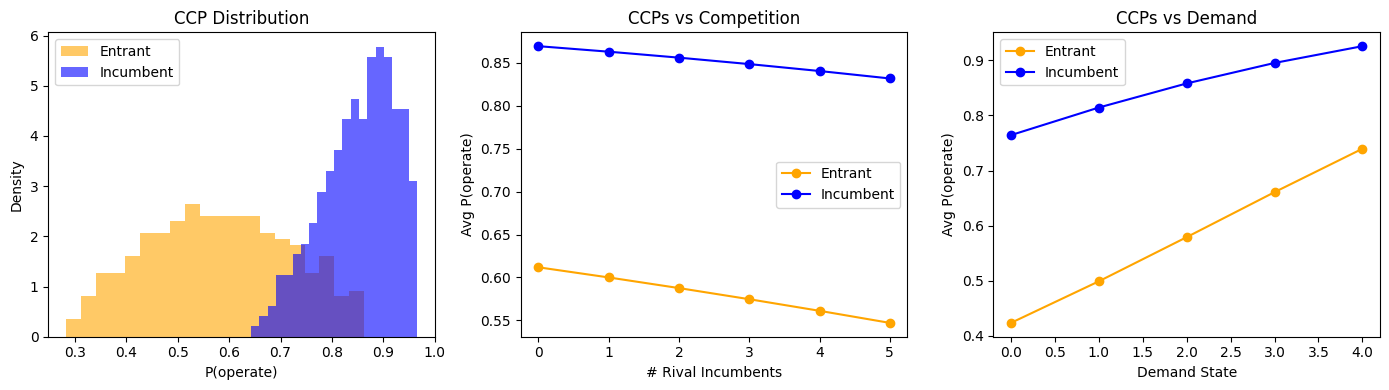

In [13]:
# Visualize equilibrium
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
ss = game.state_space

# 1. Distribution by incumbency
for incumbent, label, color in [(0, 'Entrant', 'orange'), (1, 'Incumbent', 'blue')]:
    mask = [ss.index_to_state(i)[1] == incumbent for i in range(ss.n_states)]
    axes[0].hist(eq_ccps[mask], bins=20, alpha=0.6, label=label, color=color, density=True)
axes[0].set_xlabel('P(operate)')
axes[0].set_ylabel('Density')
axes[0].set_title('CCP Distribution')
axes[0].legend()

# 2. CCPs vs # rivals
for incumbent, label, color in [(0, 'Entrant', 'orange'), (1, 'Incumbent', 'blue')]:
    means = [np.mean([eq_ccps[i] for i in range(ss.n_states) 
                      if ss.index_to_state(i)[1]==incumbent and ss.index_to_state(i)[2]==n])
             for n in range(game.params.n_firms)]
    axes[1].plot(range(game.params.n_firms), means, 'o-', label=label, color=color)
axes[1].set_xlabel('# Rival Incumbents')
axes[1].set_ylabel('Avg P(operate)')
axes[1].set_title('CCPs vs Competition')
axes[1].legend()

# 3. CCPs vs demand
for incumbent, label, color in [(0, 'Entrant', 'orange'), (1, 'Incumbent', 'blue')]:
    means = [np.mean([eq_ccps[i] for i in range(ss.n_states) 
                      if ss.index_to_state(i)[1]==incumbent and ss.index_to_state(i)[3]==s])
             for s in range(game.params.n_demand_states)]
    axes[2].plot(range(game.params.n_demand_states), means, 'o-', label=label, color=color)
axes[2].set_xlabel('Demand State')
axes[2].set_ylabel('Avg P(operate)')
axes[2].set_title('CCPs vs Demand')
axes[2].legend()

plt.tight_layout()
plt.show()

---
## 2.4 Simulation

Generate panel data from equilibrium CCPs.

In [14]:
@dataclass
class SimulationConfig:
    """Configuration for simulation."""
    n_markets: int = 3000
    n_periods: int = 20
    burn_in: int = 10
    seed: int = 42


class Simulator:
    """
    Simulate panel data from the entry-exit game.
    
    Generates firm-level observations with state variables and choices.
    Each observation includes:
    - market_char: Time-invariant market characteristic
    - demand_state: Current demand realization
    - incumbent: Whether firm was active last period
    - n_incumbent_rivals: Number of rival incumbents
    - choice: Firm's entry/stay decision (0 or 1)
    """
    
    def __init__(self, game: EntryExitGame, ccps: np.ndarray, config: SimulationConfig):
        self.game = game
        self.ccps = ccps
        self.config = config
    
    def simulate(self) -> pd.DataFrame:
        """
        Simulate panel data.

        Returns
        -------
        pd.DataFrame
            Columns: market_id, period, firm_id, market_char, demand_state, 
                     incumbent, n_incumbent_rivals, choice
        """
        np.random.seed(self.config.seed)
        
        params = self.game.params
        state_space = self.game.state_space
        demand_transition = self.game._demand_transition
        demand_cumsum = np.cumsum(demand_transition, axis=1)
        
        records = []
        
        for market_id in range(self.config.n_markets):
            # Market-level permanent characteristic (drawn once per market)
            market_char = np.random.randint(0, params.n_market_types)
            
            # Initialize demand state and incumbent status for all firms
            demand_state = np.random.randint(0, params.n_demand_states)
            is_incumbent = np.zeros(params.n_firms, dtype=int)
            
            for period in range(self.config.n_periods):
                total_incumbents = is_incumbent.sum()
                choices = np.zeros(params.n_firms, dtype=int)
                
                for firm_id in range(params.n_firms):
                    own_incumbent = is_incumbent[firm_id]
                    n_incumbent_rivals = total_incumbents - own_incumbent
                    
                    # Get CCP and make choice
                    state_idx = state_space.state_to_index(
                        (market_char, own_incumbent, n_incumbent_rivals, demand_state)
                    )
                    prob_operate = self.ccps[state_idx]
                    choices[firm_id] = 1 if np.random.rand() < prob_operate else 0
                    
                    # Record observation (after burn-in period)
                    if period >= self.config.burn_in:
                        records.append({
                            'market_id': market_id,
                            'period': period - self.config.burn_in,
                            'firm_id': firm_id,
                            'market_char': market_char,
                            'demand_state': demand_state,
                            'incumbent': own_incumbent,
                            'n_incumbent_rivals': n_incumbent_rivals,
                            'choice': choices[firm_id]
                        })
                
                # Update state for next period
                is_incumbent = choices.copy()
                demand_state = np.searchsorted(demand_cumsum[demand_state], np.random.rand())
                demand_state = min(demand_state, params.n_demand_states - 1)
        
        return pd.DataFrame(records)

In [15]:
# Simulate data
print("=" * 70)
print("Simulated Data")
print("=" * 70)

sim_config = SimulationConfig(n_markets=3000, n_periods=20, burn_in=10, seed=42)
simulator = Simulator(game, eq_ccps, sim_config)

data = simulator.simulate()

print(f"\nObservations: {len(data):,}")
print(f"Markets: {data['market_id'].nunique()}")
print(f"Periods: {data['period'].nunique()}")

print(f"\nSummary Statistics:")
summary_stats = [
    ["Overall operate rate", f"{data['choice'].mean():.3f}"],
    ["Entry rate (non-inc)", f"{data[data['incumbent']==0]['choice'].mean():.3f}"],
    ["Stay rate (inc)", f"{data[data['incumbent']==1]['choice'].mean():.3f}"]
]
print(tabulate(summary_stats, headers=["Metric", "Value"], tablefmt="simple"))

print(f"\nFirst few rows:")
print(tabulate(data.head(10), headers='keys', tablefmt='simple', showindex=False))

Simulated Data

Observations: 180,000
Markets: 3000
Periods: 10

Summary Statistics:
Metric                  Value
--------------------  -------
Overall operate rate    0.776
Entry rate (non-inc)    0.517
Stay rate (inc)         0.85

First few rows:
  market_id    period    firm_id    market_char    demand_state    incumbent    n_incumbent_rivals    choice
-----------  --------  ---------  -------------  --------------  -----------  --------------------  --------
          0         0          0              6               1            1                     3         1
          0         0          1              6               1            1                     3         1
          0         0          2              6               1            1                     3         0
          0         0          3              6               1            0                     4         0
          0         0          4              6               1            1                   

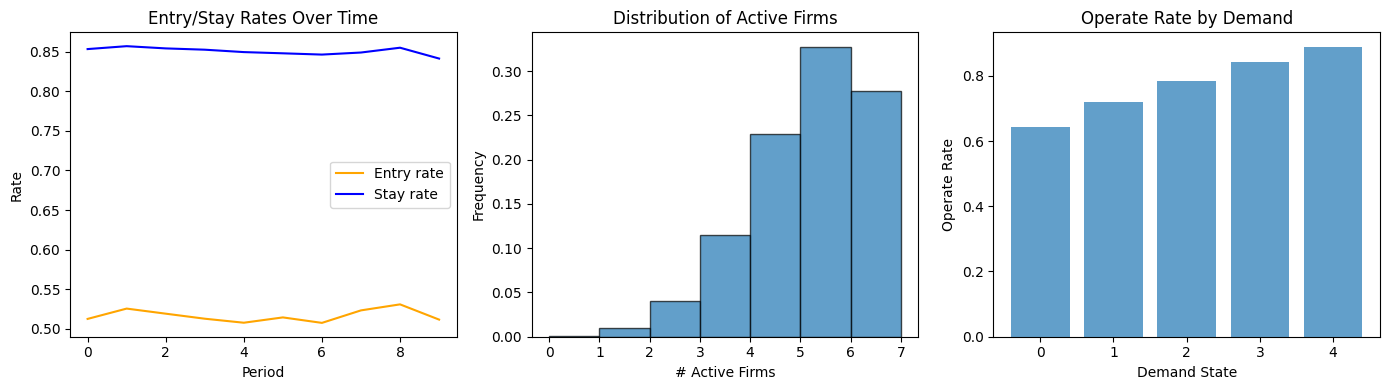

In [16]:
# Visualize simulated data
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1. Operate rate over time
entry_rate = data[data['incumbent']==0].groupby('period')['choice'].mean()
stay_rate = data[data['incumbent']==1].groupby('period')['choice'].mean()
axes[0].plot(entry_rate.index, entry_rate.values, label='Entry rate', color='orange')
axes[0].plot(stay_rate.index, stay_rate.values, label='Stay rate', color='blue')
axes[0].set_xlabel('Period')
axes[0].set_ylabel('Rate')
axes[0].set_title('Entry/Stay Rates Over Time')
axes[0].legend()

# 2. Distribution of active firms
n_active = data.groupby(['market_id', 'period'])['choice'].sum()
axes[1].hist(n_active, bins=range(game.params.n_firms+2), density=True, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('# Active Firms')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Active Firms')

# 3. Operate rate by demand state
rate_by_s = data.groupby('demand_state')['choice'].mean()
axes[2].bar(rate_by_s.index, rate_by_s.values, alpha=0.7)
axes[2].set_xlabel('Demand State')
axes[2].set_ylabel('Operate Rate')
axes[2].set_title('Operate Rate by Demand')

plt.tight_layout()
plt.show()

---
## 2.5 Saving and Loading Data

| Column | Description |
|--------|-------------|
| `market_id` | Market identifier |
| `period` | Time period |
| `firm_id` | Firm within market |
| `market_char` | Permanent market characteristic |
| `demand_state` | Current demand state |
| `incumbent` | Was firm active last period? |
| `n_incumbent_rivals` | Number of rival incumbents |
| `choice` | Operate (1) or not (0) |

In [17]:
# Save simulated data
import os

# Create output directory if needed
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)
print("=" * 70)
print("Saving Simulated Data")
print("=" * 70)

# Save as CSV (portable, human-readable)
csv_path = os.path.join(output_dir, 'simulated_data.csv')
data.to_csv(csv_path, index=False)
print(f"Saved CSV: {csv_path} ({os.path.getsize(csv_path)/1024:.1f} KB)")

# Save as Parquet if available (efficient, recommended for large data)
parquet_path = os.path.join(output_dir, 'simulated_data.parquet')
try:
    data.to_parquet(parquet_path, index=False)
    print(f"Saved Parquet: {parquet_path} ({os.path.getsize(parquet_path)/1024:.1f} KB)")
except ImportError:
    print("Parquet not available (install pyarrow or fastparquet). Skipping.")
    parquet_path = None

# Save equilibrium CCPs and parameters for reproducibility
import json as json_module

metadata = {
    'params': {
        'intercept': DEFAULT_PARAMS.intercept,
        'market_coef': DEFAULT_PARAMS.market_coef,
        'demand_coef': DEFAULT_PARAMS.demand_coef,
        'competition_coef': DEFAULT_PARAMS.competition_coef,
        'entry_cost': DEFAULT_PARAMS.entry_cost,
        'discount_factor': DEFAULT_PARAMS.discount_factor,
        'demand_persistence': DEFAULT_PARAMS.demand_persistence,
        'n_firms': DEFAULT_PARAMS.n_firms,
        'n_market_types': DEFAULT_PARAMS.n_market_types,
        'n_demand_states': DEFAULT_PARAMS.n_demand_states,
    },
    'simulation': {
        'n_markets': sim_config.n_markets,
        'n_periods': sim_config.n_periods,
        'burn_in': sim_config.burn_in,
        'seed': sim_config.seed,
    }
}

# Save metadata
meta_path = os.path.join(output_dir, 'simulation_metadata.json')
with open(meta_path, 'w') as f:
    json_module.dump(metadata, f, indent=2)
print(f"Saved metadata: {meta_path}")

# Save equilibrium CCPs
ccps_path = os.path.join(output_dir, 'equilibrium_ccps.npy')
np.save(ccps_path, eq_ccps)
print(f"Saved CCPs: {ccps_path}")

Saving Simulated Data
Saved CSV: output/simulated_data.csv (3274.9 KB)
Parquet not available (install pyarrow or fastparquet). Skipping.
Saved metadata: output/simulation_metadata.json
Saved CCPs: output/equilibrium_ccps.npy


In [18]:
# Load data back
print("=" * 70)
print("Loading Simulated Data")
print("=" * 70)

# From CSV
data_loaded_csv = pd.read_csv(csv_path)
print(f"From CSV: {len(data_loaded_csv):,} rows")

# From Parquet (if available)
if parquet_path and os.path.exists(parquet_path):
    data_loaded_parquet = pd.read_parquet(parquet_path)
    print(f"From Parquet: {len(data_loaded_parquet):,} rows")

# Load metadata
with open(meta_path, 'r') as f:
    meta_loaded = json_module.load(f)

theta_names = ['intercept', 'market_coef', 'demand_coef', 'competition_coef', 'entry_cost']
print(f"\nLoaded parameters: θ = {[meta_loaded['params'][name] for name in theta_names]}")

# Load CCPs
ccps_loaded = np.load(ccps_path)
print(f"Loaded CCPs: shape {ccps_loaded.shape}")


Loading Simulated Data
From CSV: 180,000 rows

Loaded parameters: θ = [0.0, -0.05, 0.25, -0.2, -1.5]
Loaded CCPs: shape (600,)


---
# Part 3: Estimation

## 3.1 The Big Picture: What Are We Estimating?

#### The Estimation Problem

We observe firms' entry/exit decisions across markets and time periods. We want to recover **structural parameters** $\theta = (\theta_0, \theta_1, \theta_2, \theta_3, \theta_4)$:

| Parameter | Symbol | Interpretation |
|-----------|--------|----------------|
| `intercept` | $\theta_0$ | Base profit from operating |
| `market_coef` | $\theta_1$ | Effect of market characteristic |
| `demand_coef` | $\theta_2$ | Effect of demand state |
| `competition_coef` | $\theta_3$ | Competition effect (negative) |
| `entry_cost` | $\theta_4$ | Entry cost for non-incumbents (negative) |

**Challenge**: Firms are forward-looking and play a game. The choice depends on continuation values, which are equilibrium objects.

---

#### Key Notation

| Object | Symbol | Definition |
|--------|--------|------------|
| **Primitive flow utility** | $U_j(x, d^{-i})$ | Payoff given rivals' realized actions |
| **Expected flow utility** | $u_j(x)$ | $E_{d^{-i}}[U_j]$ integrated over rivals' CCPs |
| **Conditional value** | $v_j(x)$ | $u_j(x) + \beta E[V(x') \mid x, j]$ |
| **Ex-ante value** | $V(x)$ | $E_\varepsilon[\max_j \{v_j + \varepsilon_j\}]$ |
| **CCP** | $p_j(x)$ | $P(d=j \mid x)$ |

**Flow diagram**:
```
U_j(x, d^{-i}) --[E over rivals]--> u_j(x) --[+continuation]--> v_j(x) --[logit]--> p_j(x)
```

---

#### Deriving the Identifying Equation

**Our Goal**: We want to estimate structural parameters $\theta$ from data. To do this, we need an equation where:
- One side can be computed from **data** (observed CCPs)
- The other side is a function of **$\theta$**

**Starting Point**: The definition of conditional value function

$$v_1(x) = u_1(x;\theta) + \beta \sum_{x'} V(x') \cdot f_1(x'|x)$$

**The Problem**:
- LHS: $v_1(x)$ is not directly observed
- RHS: $V(x')$ requires solving infinite-horizon Bellman equation

**Our Strategy**: Use properties of Type I EV errors and finite dependence to express both sides in terms of **observable CCPs**.

---

**Step 1: Transform the LHS — Hotz-Miller Inversion**

We cannot observe $v_1(x)$ directly, but we CAN estimate CCPs from data!

The choice rule is: $d=1$ iff $v_1 + \varepsilon_1 > v_0 + \varepsilon_0$

Using the key property that the difference of two i.i.d. Gumbels follows a Logistic distribution:
$$p_j = \frac{\exp(v_j)}{\sum_k \exp(v_k)}$$

Taking the ratio of CCPs:
$$\frac{p_1}{p_0} = \frac{\exp(v_1)}{\exp(v_0)} = \exp(v_1 - v_0)$$

Taking logs gives us the **Hotz-Miller Inversion**:
$$\boxed{v_1 - v_0 = \log\left(\frac{p_1(x)}{p_0(x)}\right) = \log\left(\frac{p_1(x)}{1-p_1(x)}\right)}$$

---

**Step 2: Transform the RHS — Ex-ante Value**

The RHS contains $V(x')$. Computing this normally requires infinite recursion.

With Type I EV errors, the ex-ante value has a closed form:
$$V(x) = E_\varepsilon[\max_j\{v_j + \varepsilon_j\}] = \gamma + \log\left(\sum_j \exp(v_j)\right)$$

where $\gamma \approx 0.5772$ is Euler's constant. This can be rewritten as:
$$V(x) = \gamma + \log\left(\exp(v_0)(1 + \exp(v_1 - v_0))\right) = \gamma + v_0 + \log(1 + \exp(v_1 - v_0))$$

Using the CCP formula, we can show $1 + \exp(v_1 - v_0) = 1/p_0 = 1/(1-p_1)$:
$$\boxed{V(x) = \gamma + v_0 - \log(1-p_1)}$$

---

**Step 3: Combine — The Identifying Equation**

Substituting both results into $v_1(x) = u_1(x;\theta) + \beta \sum_{x'} V(x') \cdot f_1(x'|x)$:

$$\boxed{\log\left(\frac{p_1(x)}{1-p_1(x)}\right) + v_0 =
u_1(x;\theta) + \beta \sum_{x'} \left[\gamma + v_0 - \log(1-p_1(x'))\right] \cdot f_1(x'\mid x)}$$

| Term | Source |
|------|--------|
| $\log(p_1/(1-p_1))$ | Data (estimate CCPs) |
| $u_1(x;\theta)$ | Linear function of $\theta$ |
| $\gamma - \log(1-p_1(x'))$ | Data (estimate CCPs) |
| $f_1(x'\|x)$ | Data (estimate transitions) |

**Result**: Everything is either estimable from data or a function of $\theta$.

$\Rightarrow$ We can solve for $\theta$ using regression or GMM!

---

#### Finite Dependence

Exit ($d=0$) is a **terminal action**: once a firm exits, it receives zero
future payoffs (not just by normalization, but by the economic structure).
Therefore $v_0(x) = 0$ is an **economic fact**, not just a normalization!

**Key insight**: Because exit ends the game, we have $v_0(x) = 0$ as an
economic fact, not just a normalization, and hence continuation value depends only on CCPs:
$$E[V(x') \mid x, d=1] = \sum_{x'} [\gamma - \log(1 - p_1(x'))] \cdot f_1(x'|x)$$

**Why this matters**:
- With terminal exit: V(x') = γ - log(1 - p₁(x')) depends ONLY on CCPs
- Without terminal action: V(x') requires solving infinite recursion
- This is what makes CCP methods tractable in this model

With $v_0 = 0$:
- LHS: $v_1 - v_0 = v_1 = \log\left(\frac{p_1}{1-p_1}\right)$
- RHS: $V(x) = \gamma + 0 - \log(1-p_1) = \gamma - \log(1-p_1)$

---

#### Two Estimation Approaches

| | **NFXP** | **CCP Methods** |
|---|---|---|
| Core idea | Solve equilibrium for each $\theta$ | Use data CCPs directly |
| Equilibrium solved | Every likelihood evaluation | Never during estimation |
| Computation | Expensive | Fast |
| Efficiency | MLE (optimal) | $\leq$ MLE |

**NFXP**: Outer loop optimizes $\theta$; inner loop solves $p^*(\theta)$.

**CCP Methods**: Estimate CCPs once from data, use in estimation equation.

---
## 3.2 NFXP Estimator (Full Solution Method)

The **Nested Fixed Point** approach (Rust 1987) solves the equilibrium at each parameter guess.

#### Algorithm

```
For each θ proposed by optimizer:
    1. Solve for equilibrium CCPs: p*(θ)
    2. Compute log-likelihood: L(θ) = Σᵢ log p*(xᵢ, dᵢ; θ)
Repeat until optimizer converges
```

#### Properties

- **Efficiency**: Achieves MLE (fully efficient)
- **Computation**: Very expensive (equilibrium solved at every $\theta$ evaluation)
- **Robustness**: Sensitive to starting values; requires correct specification

In [19]:
@dataclass
class EstimationResult:
    """Results from structural estimation."""
    theta: np.ndarray
    se: np.ndarray = None
    computation_time: float = 0.0
    method: str = ""
    n_iterations: int = 0
    n_equilibrium_solves: int = 0
    converged: bool = True


class NFXPEstimator:
    """
    Nested Fixed Point (NFXP) estimator.

    Solves equilibrium at each θ evaluation to compute likelihood.
    Achieves MLE efficiency but computationally expensive.
    """

    def __init__(self, game: EntryExitGame, data: pd.DataFrame,
                 eq_tolerance: float = 1e-8, verbose: bool = True):
        self.game = game
        self.data = data
        self.eq_tolerance = eq_tolerance
        self.verbose = verbose
        self._precompute()
        self.n_equilibrium_solves = 0
        self.n_likelihood_evals = 0

    def _precompute(self):
        """Precompute state indices for observations."""
        self.y = self.data['choice'].values
        self.state_indices = np.array([
            self.game.state_space.state_to_index((
                int(row['market_char']),
                int(row['incumbent']),
                int(row['n_incumbent_rivals']),
                int(row['demand_state'])
            )) for _, row in self.data.iterrows()
        ])

    def log_likelihood(self, theta: np.ndarray) -> float:
        """Compute log-likelihood (solves equilibrium inside)."""
        self.n_likelihood_evals += 1

        # Create game with candidate parameters
        fixed_params = dict(
            discount_factor=self.game.params.discount_factor,
            demand_persistence=self.game.params.demand_persistence,
            n_firms=self.game.params.n_firms,
            n_market_types=self.game.params.n_market_types,
            n_demand_states=self.game.params.n_demand_states
        )
        temp_game = EntryExitGame(EntryExitParams.from_vector(theta, **fixed_params))

        # Solve equilibrium
        result = temp_game.solve(tolerance=self.eq_tolerance, verbose=False)
        self.n_equilibrium_solves += 1

        if not result.converged:
            return -1e10

        # Log-likelihood
        ccps = np.clip(result.solution[self.state_indices], 1e-10, 1-1e-10)
        ll = np.sum(self.y * np.log(ccps) + (1-self.y) * np.log(1-ccps))

        if self.verbose and self.n_likelihood_evals % 10 == 0:
            print(f"  Eval {self.n_likelihood_evals}: LL = {ll:.2f}")

        return ll

    def estimate(self, theta_init: np.ndarray = None) -> 'EstimationResult':
        """Run NFXP estimation."""
        start = time.time()
        self.n_equilibrium_solves = 0
        self.n_likelihood_evals = 0

        if theta_init is None:
            theta_init = self.game.params.theta_vector()

        if self.verbose:
            print("NFXP: Solving equilibrium at each θ evaluation...")

        result = minimize(
            lambda theta: -self.log_likelihood(theta),
            theta_init,
            method='BFGS',
            options={'disp': False, 'gtol': 1e-5}
        )

        # Standard errors from Hessian
        se = None
        if result.success and hasattr(result, 'hess_inv'):
            try:
                se = np.sqrt(np.diag(result.hess_inv))
            except:
                pass

        return EstimationResult(
            theta=result.x, se=se,
            computation_time=time.time() - start,
            method="NFXP",
            n_iterations=result.nit if hasattr(result, 'nit') else 0,
            n_equilibrium_solves=self.n_equilibrium_solves,
            converged=result.success
        )

In [20]:
# Run NFXP estimation
print("=" * 70)
print("NFXP Estimation")
print("=" * 70)

est_nfxp = NFXPEstimator(game, data, verbose=True)
result_nfxp = est_nfxp.estimate()

print(f"\nTime: {result_nfxp.computation_time:.2f}s")
print(f"Equilibrium solves: {result_nfxp.n_equilibrium_solves}")
print(f"Converged: {result_nfxp.converged}\n")

true_theta = DEFAULT_PARAMS.theta_vector()
param_names = ['intercept', 'market_coef', 'demand_coef', 'competition_coef', 'entry_cost']

rows = [[n, f'{t:.3f}', f'{e:.3f}', f'{e-t:+.3f}']
        for n, t, e in zip(param_names, true_theta, result_nfxp.theta)]
print(tabulate(rows, headers=['Parameter', 'True', 'Est', 'Bias'], tablefmt='simple'))

NFXP Estimation
NFXP: Solving equilibrium at each θ evaluation...
  Eval 10: LL = -925961.31
  Eval 20: LL = -82626.33
  Eval 30: LL = -82619.01
  Eval 40: LL = -82621.57
  Eval 50: LL = -82618.92
  Eval 60: LL = -82618.92
  Eval 70: LL = -82618.84
  Eval 80: LL = -82618.82
  Eval 90: LL = -82618.82
  Eval 100: LL = -82618.82

Time: 44.29s
Equilibrium solves: 108
Converged: False

Parameter           True     Est    Bias
----------------  ------  ------  ------
intercept           0      0.008   0.008
market_coef        -0.05  -0.05    0
demand_coef         0.25   0.253   0.003
competition_coef   -0.2   -0.203  -0.003
entry_cost         -1.5   -1.5     0


---
## 3.3 CCP Estimation: First Stage

All CCP methods require first-stage estimates of $\hat{p}(x) = P(d=1|x)$.

#### Estimation Approaches

1. **Frequency**: Cell-by-cell means. Non-parametric but needs many observations per state.
2. **Logit**: Flexible logit with interactions. Smooths across states.

The key insight: if data comes from equilibrium, observed CCPs **are** equilibrium CCPs.

In [21]:
class FirstStageEstimator:
    """First-stage CCP estimation from data."""

    def __init__(self, data: pd.DataFrame, state_space: StateSpace):
        self.data = data
        self.state_space = state_space

    def estimate_frequency(self) -> np.ndarray:
        """Cell-by-cell frequency estimator."""
        n_states = self.state_space.n_states
        ccps = np.full(n_states, 0.5)

        for idx in range(n_states):
            state = self.state_space.index_to_state(idx)
            x1, inc, n_rivals, s = state
            mask = ((self.data['market_char'] == x1) &
                    (self.data['incumbent'] == inc) &
                    (self.data['n_incumbent_rivals'] == n_rivals) &
                    (self.data['demand_state'] == s))
            if mask.sum() > 0:
                ccps[idx] = self.data.loc[mask, 'choice'].mean()

        return np.clip(ccps, 0.01, 0.99)

    def estimate_logit(self) -> Tuple[np.ndarray, Any]:
        """Logit estimator with interactions."""
        from sklearn.linear_model import LogisticRegression

        df = self.data
        X = np.column_stack([
            df['market_char'], df['demand_state'], df['n_incumbent_rivals'],
            df['incumbent'], df['market_char'] * df['incumbent'],
            df['demand_state'] * df['incumbent'],
            df['n_incumbent_rivals'] * df['incumbent']
        ])
        y = df['choice'].values

        model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
        model.fit(X, y)

        # Predict for all states
        X_all = np.zeros((self.state_space.n_states, 7))
        for idx in range(self.state_space.n_states):
            x1, inc, n_rivals, s = self.state_space.index_to_state(idx)
            X_all[idx] = [x1, s, n_rivals, inc, x1*inc, s*inc, n_rivals*inc]

        return np.clip(model.predict_proba(X_all)[:, 1], 0.01, 0.99), model

In [22]:
# First-stage CCP estimation
print("=" * 70)
print("First Stage: CCP Estimation")
print("=" * 70)

first_stage = FirstStageEstimator(data, game.state_space)
ccps_freq = first_stage.estimate_frequency()
ccps_logit, _ = first_stage.estimate_logit()

print("\nComparison to True Equilibrium CCPs:")
results = [
    ["Frequency", f"{np.corrcoef(eq_ccps, ccps_freq)[0,1]:.4f}",
     f"{np.mean(np.abs(eq_ccps - ccps_freq)):.4f}"],
    ["Logit", f"{np.corrcoef(eq_ccps, ccps_logit)[0,1]:.4f}",
     f"{np.mean(np.abs(eq_ccps - ccps_logit)):.4f}"]
]
print(tabulate(results, headers=["Method", "Correlation", "MAE"], tablefmt="simple"))

ccps_hat = ccps_logit
print(f"\nUsing logit estimator for structural estimation.")

First Stage: CCP Estimation

Comparison to True Equilibrium CCPs:
Method       Correlation     MAE
---------  -------------  ------
Frequency         0.8279  0.0605
Logit             0.9984  0.0084

Using logit estimator for structural estimation.


---
## 3.4 CCP Estimation: Two-Stage

The simplest CCP method (Hotz & Miller 1993). No iteration required.

#### Algorithm

1. **Stage 1**: Estimate CCPs $\hat{p}$ from data
2. **Stage 2**: Solve linear equation with $\hat{p}$ fixed

#### The Identifying Equation

From the model:
$$\log\frac{p_1}{1-p_1} = v_1 = u_1(x;\theta) + \beta \cdot E[V(x') | x, d=1]$$

Rearranging with Hotz-Miller inversion:
$$\underbrace{\log\frac{\hat{p}}{1-\hat{p}} - \beta \cdot E[V(x') | x, d=1]}_{Y(x)} = \underbrace{\theta_0 + \theta_1 x_1 + \theta_2 s + \theta_3 E[n^*] + \theta_4 \cdot \mathbf{1}\{\text{ent}\}}_{X(x)'\theta}$$

**Linear in $\theta$!** Use OLS/WLS.

#### Properties

- **Consistent**: Yes
- **Efficient**: < MLE (ignores first-stage estimation error)
- **Computation**: Very fast (just regression)

In [23]:
class MomentConditions:
    """Construct moment conditions from Hotz-Miller inversion."""

    def __init__(self, game: EntryExitGame):
        self.game = game

    def construct_Y(self, ccps: np.ndarray) -> np.ndarray:
        """LHS: log-odds minus continuation value."""
        return log_odds(ccps) - self.game.discount * self.game.continuation_value_diff(ccps)

    def construct_X(self, ccps: np.ndarray) -> np.ndarray:
        """RHS: [1, x1, s, E[n_active], is_entrant]."""
        n_states = self.game.state_space.n_states
        X = np.zeros((n_states, 5))

        for idx in range(n_states):
            x1, inc, n_rival_inc, s = self.game.state_space.index_to_state(idx)
            n_rival_ent = self.game.params.n_firms - 1 - n_rival_inc
            p_enter, p_stay = self.game._get_rival_ccps(n_rival_inc, x1, s, inc, ccps)
            exp_n_active = n_rival_inc * p_stay + n_rival_ent * p_enter
            X[idx] = [1, x1, s, exp_n_active, 1 - inc]

        return X


class TwoStageEstimator:
    """Two-stage CCP estimator (Hotz-Miller 1993)."""

    def __init__(self, game: EntryExitGame, data: pd.DataFrame):
        self.game = game
        self.data = data
        self.first_stage = FirstStageEstimator(data, game.state_space)

    def estimate(self, ccps: np.ndarray = None) -> EstimationResult:
        start = time.time()

        if ccps is None:
            ccps, _ = self.first_stage.estimate_logit()

        moments = MomentConditions(self.game)
        Y = moments.construct_Y(ccps)
        X = moments.construct_X(ccps)

        # Weights by observation count
        weights = self._compute_weights()
        W = np.diag(weights)

        # WLS
        XtWX = X.T @ W @ X
        theta = np.linalg.solve(XtWX, X.T @ W @ Y)

        # Standard errors
        resid = Y - X @ theta
        sigma2 = np.sum(weights * resid**2) / (np.sum(weights > 0) - 5)
        se = np.sqrt(np.diag(sigma2 * np.linalg.inv(XtWX)))

        return EstimationResult(theta=theta, se=se,
                               computation_time=time.time()-start,
                               method="Two-Stage")

    def _compute_weights(self) -> np.ndarray:
        weights = np.zeros(self.game.state_space.n_states)
        for idx in range(self.game.state_space.n_states):
            x1, inc, n_rivals, s = self.game.state_space.index_to_state(idx)
            mask = ((self.data['market_char'] == x1) & (self.data['incumbent'] == inc) &
                    (self.data['n_incumbent_rivals'] == n_rivals) & (self.data['demand_state'] == s))
            weights[idx] = mask.sum()
        return weights

In [24]:
# Two-Stage estimation
print("=" * 70)
print("Two-Stage Estimation")
print("=" * 70)

est_2stage = TwoStageEstimator(game, data)
result_2stage = est_2stage.estimate(ccps_hat)

print(f"Time: {result_2stage.computation_time:.3f}s\n")

rows = [[n, f'{t:.3f}', f'{e:.3f}', f'({se:.3f})', f'{e-t:+.3f}']
        for n, t, e, se in zip(param_names, true_theta, result_2stage.theta, result_2stage.se)]
print(tabulate(rows, headers=['Parameter', 'True', 'Est', 'SE', 'Bias'], tablefmt='simple'))

Two-Stage Estimation
Time: 0.139s

Parameter           True     Est  SE         Bias
----------------  ------  ------  -------  ------
intercept           0     -0.12   (0.024)  -0.12
market_coef        -0.05  -0.045  (0.001)   0.005
demand_coef         0.25   0.24   (0.002)  -0.01
competition_coef   -0.2   -0.169  (0.006)   0.031
entry_cost         -1.5   -1.503  (0.004)  -0.003


---
## 3.5 CCP Estimation: CCP-Model (NPL)

**Nested Pseudo Likelihood** (Aguirregabiria & Mira 2007) iterates between estimation and CCP updates.

#### Algorithm

1. Initialize CCPs $p^0$ from data
2. **Iterate**:
   - Given $p^k$: estimate $\theta^{k+1}$ (Two-Stage step)
   - Given $\theta^{k+1}$: update $p^{k+1} = \Psi(p^k; \theta^{k+1})$
3. Repeat until convergence

#### The CCP Operator $\Psi$

Given CCPs and $\theta$, compute best-response CCPs:
$$\Psi(p; \theta) = \Lambda(u(\theta) + \beta \cdot CV(p))$$

#### Properties

- **$K=0$**: Equivalent to Two-Stage
- **$K \to \infty$**: Approaches MLE
- **Warning**: May converge to wrong fixed point (Aguirregabiria & Mira 2007, Section 5)

#### Note on CCP-Data

Arcidiacono & Miller (2011) also propose "CCP-Data" which re-estimates CCPs from data each iteration. **Without unobserved heterogeneity, CCP-Data is equivalent to Two-Stage** since the data-based CCP update doesn't depend on $\theta$. We omit it here.

In [25]:
class CCPModelEstimator:
    """
    CCP-Model estimator (NPL with model-based CCP updates).

    Iterates: estimate θ → update CCPs via Ψ(p; θ) → repeat.
    """

    def __init__(self, game: EntryExitGame, data: pd.DataFrame,
                 K: int = 1, tolerance: float = 1e-6, max_iter: int = 100):
        self.game = game
        self.data = data
        self.K = K  # Policy iterations per θ update
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.first_stage = FirstStageEstimator(data, game.state_space)
        self._precompute()

    def _precompute(self):
        self.state_indices = np.array([
            self.game.state_space.state_to_index((
                int(row['market_char']), int(row['incumbent']),
                int(row['n_incumbent_rivals']), int(row['demand_state'])
            )) for _, row in self.data.iterrows()
        ])

    def _estimate_theta(self, ccps: np.ndarray) -> np.ndarray:
        """Estimate θ given CCPs (Two-Stage step)."""
        moments = MomentConditions(self.game)
        Y = moments.construct_Y(ccps)
        X = moments.construct_X(ccps)

        weights = np.array([np.sum(self.state_indices == idx)
                           for idx in range(self.game.state_space.n_states)])
        W = np.diag(weights)
        return np.linalg.solve(X.T @ W @ X, X.T @ W @ Y)

    def _update_ccps(self, ccps: np.ndarray, theta: np.ndarray) -> np.ndarray:
        """Update CCPs via model: p = Ψ(p; θ)."""
        fixed = dict(
            discount_factor=self.game.params.discount_factor,
            demand_persistence=self.game.params.demand_persistence,
            n_firms=self.game.params.n_firms,
            n_market_types=self.game.params.n_market_types,
            n_demand_states=self.game.params.n_demand_states
        )
        temp_game = EntryExitGame(EntryExitParams.from_vector(theta, **fixed))

        ccps_new = ccps.copy()
        for _ in range(self.K):
            ccps_new = temp_game.ccp_operator(ccps_new)
        return ccps_new

    def estimate(self, ccps_init: np.ndarray = None) -> EstimationResult:
        start = time.time()

        ccps = ccps_init if ccps_init is not None else self.first_stage.estimate_logit()[0]
        theta = self.game.params.theta_vector()

        for iteration in range(self.max_iter):
            theta_old = theta.copy()
            theta = self._estimate_theta(ccps)
            ccps = self._update_ccps(ccps, theta)

            if np.max(np.abs(theta - theta_old)) < self.tolerance:
                return EstimationResult(
                    theta=theta, computation_time=time.time()-start,
                    method=f"CCP-Model (K={self.K})",
                    n_iterations=iteration+1, converged=True)

        return EstimationResult(
            theta=theta, computation_time=time.time()-start,
            method=f"CCP-Model (K={self.K})",
            n_iterations=self.max_iter, converged=False)

In [26]:
# CCP-Model estimation
print("=" * 70)
print("CCP-Model Estimation (K=1)")
print("=" * 70)

est_ccp_model = CCPModelEstimator(game, data, K=1)
result_ccp_model = est_ccp_model.estimate(ccps_hat)

print(f"Time: {result_ccp_model.computation_time:.3f}s")
print(f"Iterations: {result_ccp_model.n_iterations}")
print(f"Converged: {result_ccp_model.converged}\n")

rows = [[n, f'{t:.3f}', f'{e:.3f}', f'{e-t:+.3f}']
        for n, t, e in zip(param_names, true_theta, result_ccp_model.theta)]
print(tabulate(rows, headers=['Parameter', 'True', 'Est', 'Bias'], tablefmt='simple'))

CCP-Model Estimation (K=1)
Time: 1.079s
Iterations: 24
Converged: True

Parameter           True     Est    Bias
----------------  ------  ------  ------
intercept           0     -0.164  -0.164
market_coef        -0.05  -0.043   0.007
demand_coef         0.25   0.23   -0.02
competition_coef   -0.2   -0.155   0.045
entry_cost         -1.5   -1.508  -0.008


---
## 3.6 Comparison of Methods

#### Summary

| Method | Solves Eq? | Iterations | Efficiency | Speed |
|--------|------------|------------|------------|-------|
| **NFXP** | Yes, every $\theta$ | N/A | MLE | Slow |
| **Two-Stage** | No | 0 | < MLE | Fast |
| **CCP-Model** | No | K per update | → MLE | Medium |

#### Key Trade-offs

1. **NFXP**: Full efficiency but expensive. Use as benchmark.
2. **Two-Stage**: Fast, one-shot. Good for initial estimates or large state spaces.
3. **CCP-Model**: Iteratively improves on Two-Stage. Watch for convergence issues.


In [27]:
# Comparison table
print("\n" + "=" * 70)
print("Comparison of Estimation Methods")
print("=" * 70 + "\n")

methods = ['NFXP', 'Two-Stage', 'CCP-Model']
results = {
    'NFXP': result_nfxp,
    'Two-Stage': result_2stage,
    'CCP-Model': result_ccp_model
}

# Parameter estimates
print(f"{'':18} {'True':>8}" + "".join([f" {m:>12}" for m in methods]))
print("-" * 62)

for i, name in enumerate(param_names):
    row = f"{name:18} {true_theta[i]:>8.3f}"
    for m in methods:
        row += f" {results[m].theta[i]:>12.3f}"
    print(row)

print("-" * 62)
print(f"{'Time (sec)':18} {'-':>8}" +
      "".join([f" {results[m].computation_time:>12.2f}" for m in methods]))
print(f"{'Iterations':18} {'-':>8}" +
      "".join([f" {results[m].n_iterations if results[m].n_iterations > 0 else '-':>12}" for m in methods]))
print(f"{'Equil. solves':18} {'-':>8}" +
      "".join([f" {results[m].n_equilibrium_solves if results[m].n_equilibrium_solves > 0 else '-':>12}" for m in methods]))

# RMSE
print("-" * 62)
for m in methods:
    rmse = np.sqrt(np.mean((results[m].theta - true_theta)**2))
    print(f"RMSE ({m}): {rmse:.4f}")


Comparison of Estimation Methods

                       True         NFXP    Two-Stage    CCP-Model
--------------------------------------------------------------
intercept             0.000        0.008       -0.120       -0.164
market_coef          -0.050       -0.050       -0.045       -0.043
demand_coef           0.250        0.253        0.240        0.230
competition_coef     -0.200       -0.203       -0.169       -0.155
entry_cost           -1.500       -1.500       -1.503       -1.508
--------------------------------------------------------------
Time (sec)                -        44.29         0.14         1.08
Iterations                -           10            -           24
Equil. solves             -          108            -            -
--------------------------------------------------------------
RMSE (NFXP): 0.0039
RMSE (Two-Stage): 0.0554
RMSE (CCP-Model): 0.0768
